In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TRANSFORMERS_NO_TF'] = '1'

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

plt.rcParams["figure.figsize"] = (7, 5)


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU")


✓ Using Apple Silicon GPU (MPS)


In [3]:
df = pd.read_csv("../data/training_sentences.csv")
df = df.rename(columns={"sentence": "text"})

print(f"Total samples: {len(df)}")
print(df["label_id"].value_counts())


Total samples: 4747
label_id
1    3755
0     992
Name: count, dtype: int64


The validation split **must match training** to ensure consistent evaluation.


In [4]:
_, val_texts, _, val_labels = train_test_split(
    df["text"].tolist(),
    df["label_id"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)

print(f"Validation samples: {len(val_texts)}")


Validation samples: 950


In [5]:
model_path = "../models/specificity"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model.to(device)
model.eval()

print("✓ Model and tokenizer loaded")


✓ Model and tokenizer loaded


In [6]:
def get_prediction_scores(texts, labels):
    probs = []
    true_labels = []

    with torch.no_grad():
        for text, label in zip(texts, labels):
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=128
            ).to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            prob_specific = torch.softmax(logits, dim=-1)[0, 1].item()

            probs.append(prob_specific)
            true_labels.append(label)

    return np.array(probs), np.array(true_labels)


y_scores, y_true = get_prediction_scores(val_texts, val_labels)


## ROC Curve

The ROC curve evaluates the discriminative ability of the specificity classifier
across decision thresholds.


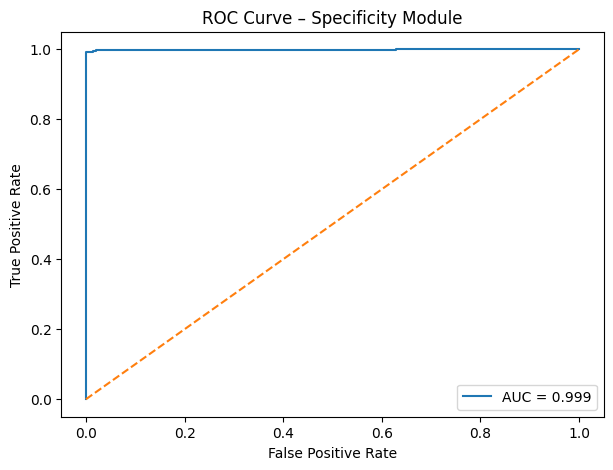

In [7]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Specificity Module")
plt.legend()
plt.show()


## Precision–Recall Curve

The PR curve is particularly informative under class imbalance.


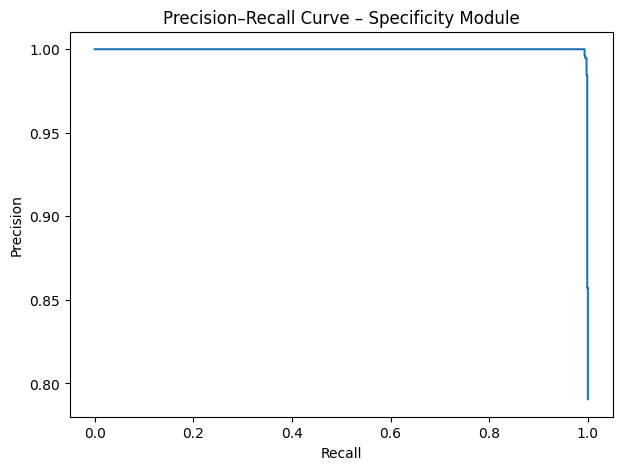

In [8]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Specificity Module")
plt.show()


## Confusion Matrix (Threshold = 0.5)


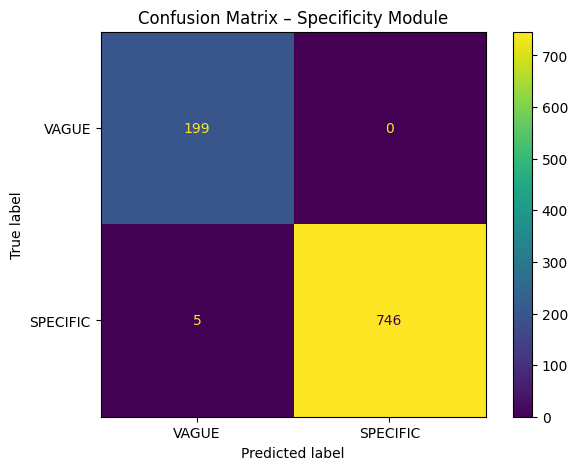

In [9]:
y_pred = (y_scores >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["VAGUE", "SPECIFIC"]
)

disp.plot()
plt.title("Confusion Matrix – Specificity Module")
plt.show()


## Threshold Sensitivity Analysis


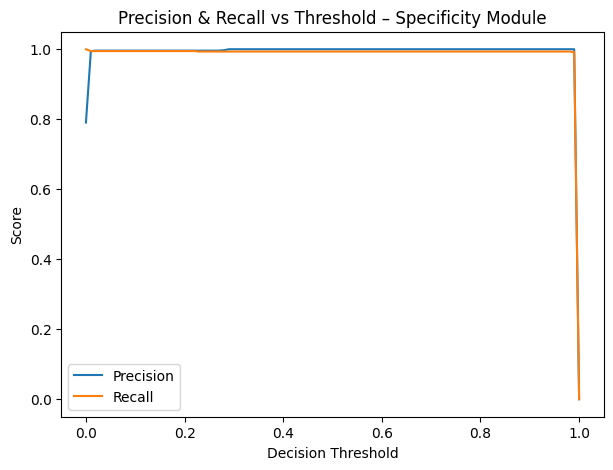

In [10]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)
precision_list = []
recall_list = []

for t in thresholds:
    preds = (y_scores >= t).astype(int)

    precision = precision_score(
        y_true, preds, zero_division=0
    )
    recall = recall_score(
        y_true, preds, zero_division=0
    )

    precision_list.append(precision)
    recall_list.append(recall)

plt.figure()
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold – Specificity Module")
plt.legend()
plt.show()


In [11]:
"""## Metrics Summary Table

Consolidated view of key performance metrics across different thresholds.

"""

# Create a comprehensive metrics table
metrics_data = []

# Add threshold-based metrics (sample every 10th threshold for readability)
for i in range(0, len(thresholds), 10):
    t = thresholds[i]
    preds = (y_scores >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    
    metrics_data.append({
        'Threshold': f'{t:.2f}',
        'Precision': f'{precision_list[i]:.3f}',
        'Recall': f'{recall_list[i]:.3f}',
        'F1-Score': f'{2 * precision_list[i] * recall_list[i] / (precision_list[i] + recall_list[i] + 1e-10):.3f}',
        'True Pos': tp,
        'True Neg': tn,
        'False Pos': fp,
        'False Neg': fn,
        'Accuracy': f'{(tp + tn) / (tp + tn + fp + fn):.3f}'
    })

metrics_df = pd.DataFrame(metrics_data)

print("=" * 100)
print("THRESHOLD SENSITIVITY METRICS")
print("=" * 100)
print(metrics_df.to_string(index=False))
print("=" * 100)

# Summary statistics at key thresholds
print("\n" + "=" * 100)
print("KEY THRESHOLD PERFORMANCE")
print("=" * 100)

key_thresholds = [0.3, 0.5, 0.7]
key_metrics = []

for t in key_thresholds:
    preds = (y_scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    
    key_metrics.append({
        'Threshold': t,
        'Precision': f'{prec:.3f}',
        'Recall': f'{rec:.3f}',
        'F1-Score': f'{2 * prec * rec / (prec + rec + 1e-10):.3f}',
        'Specificity': f'{tn / (tn + fp + 1e-10):.3f}',
        'Accuracy': f'{(tp + tn) / (tp + tn + fp + fn):.3f}',
        'ROC-AUC': f'{roc_auc:.3f}'
    })

key_df = pd.DataFrame(key_metrics)
print(key_df.to_string(index=False))
print("=" * 100)

# Overall model performance summary
print("\n" + "=" * 100)
print("OVERALL MODEL PERFORMANCE SUMMARY")
print("=" * 100)

summary_stats = pd.DataFrame([{
    'Metric': 'ROC-AUC',
    'Value': f'{roc_auc:.3f}'
}, {
    'Metric': 'Validation Samples',
    'Value': len(val_texts)
}, {
    'Metric': 'VAGUE Count',
    'Value': np.sum(y_true == 0)
}, {
    'Metric': 'SPECIFIC Count',
    'Value': np.sum(y_true == 1)
}, {
    'Metric': 'Class Balance',
    'Value': f'{np.sum(y_true == 1) / len(y_true):.2%}'
}])

print(summary_stats.to_string(index=False))
print("=" * 100)

THRESHOLD SENSITIVITY METRICS
Threshold Precision Recall F1-Score  True Pos  True Neg  False Pos  False Neg Accuracy
     0.00     0.791  1.000    0.883       751         0        199          0    0.791
     0.10     0.996  0.995    0.995       747       196          3          4    0.993
     0.20     0.996  0.995    0.995       747       196          3          4    0.993
     0.30     1.000  0.993    0.997       746       199          0          5    0.995
     0.40     1.000  0.993    0.997       746       199          0          5    0.995
     0.50     1.000  0.993    0.997       746       199          0          5    0.995
     0.60     1.000  0.993    0.997       746       199          0          5    0.995
     0.70     1.000  0.993    0.997       746       199          0          5    0.995
     0.80     1.000  0.993    0.997       746       199          0          5    0.995
     0.90     1.000  0.993    0.997       746       199          0          5    0.995
     1.00    